### Airbnb Classification

**Airbnb Business Model**

**Marketplace** that connect people who offers home with peope who wants to rent a home. 

Offert:
* Portfolio Density/Diversity
* Portfolio Size
* Average Price

Demand:
* LTV
* CAC
* Number of Users



**Business Problem**

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

**Data Description**

In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 




**Solution**
1. Predict and load in a database, use data visualization to see results

2. API: 
    * Input: id and customer features
    * Output: id + predict + probability

# 0.0. Load


## 0.1. Imports


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
import os

from scipy import stats as ss
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics 

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from keras import models as ml
from keras import layers as l

from scikitplot import metrics as mt

import random
import sweetviz


## 0.2. Helper Functions

In [14]:
def num_stats(df):
    num_attributes = df.select_dtypes(['int64', 'float64'])

    #central tendency
    mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    median = pd.DataFrame(num_attributes.apply(np.mean)).T

    #dispersion
    min_ = pd.DataFrame(num_attributes.apply(min)).T
    max_ = pd.DataFrame(num_attributes.apply(max)).T
    range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    skew  = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    std = pd.DataFrame(num_attributes.apply(np.std)).T

    m_numeric = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()

    m_numeric.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m_numeric

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

### 0.3. Load Dataset

In [15]:
df_raw = pd.read_csv('../data/train_users_2.csv', low_memory=True)
df_sessions = pd.read_csv('../data/sessions.csv')

# 1.0 EDA

In [16]:
df = df_raw.copy()

### H1: Mulheres viajam 20% a mais do que homens

#### Falso: Não tem tanta diferença por gênero

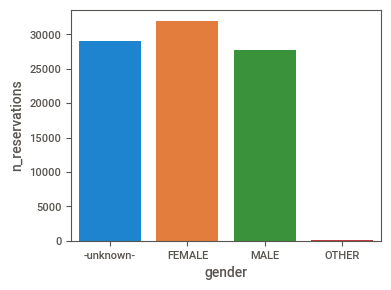

In [29]:
aux = df[df['country_destination']!='NDF'].groupby('gender').agg(n_reservations = ('id', 'count')).reset_index()

plt.figure(figsize = (4,3))
sns.barplot(data = aux, x= 'gender', y= 'n_reservations');

### H1.1 Há diferença significativa de escolha de endereço por gênero

#### Falso: A diferença é maior de acordo com a distribuição, é maior quando o número de dados é maior. Mulheres viajam mais para o US, mas também deixam de viajar também.

In [50]:
aux = df[df['gender'].isin(['MALE', 'FEMALE'])].groupby(['gender','country_destination']).agg(n_reservations = ('id', 'count')).reset_index()
aux = aux.sort_values('n_reservations')
img = px.bar(data_frame = aux, x= 'country_destination', y= 'n_reservations', color='gender', barmode= 'group')
img.show()

<Figure size 400x200 with 0 Axes>

#### H2: O tempo médio entre a criação da conta e o primeiro booking é de pelo menos 7 dias

In [ ]:
df.

#### H3: No final do ano, aumentam as viagens para os EUA e no meio do ano, para a Europa

#### H4: O menor número de reservas é no meio do ano